In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.decomposition import PCA
from sklearn import cluster, manifold
from sklearn.cluster import cluster_optics_dbscan
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC
from umap.umap_ import UMAP
from sklearn.pipeline import make_pipeline
import matplotlib.cm as cm
import seaborn as sns
from sklearn.ensemble import BaggingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Nulls

In [6]:
data = pd.read_csv('../../data/water_potability.csv')
data.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [7]:
data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [8]:
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [9]:
# fill the null values with the mean
data['ph'].fillna((data['ph'].mean()), inplace=True)
data['Sulfate'].fillna((data['Sulfate'].mean()), inplace=True)
data['Trihalomethanes'].fillna((data['Trihalomethanes'].mean()), inplace=True)


In [10]:
data.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [11]:
Y = data['Potability']
X = data.drop(columns=['Potability'])

# Outliers

In [12]:
data_minmax = MinMaxScaler().fit_transform(X.values)
pca = PCA(0.95, whiten=True)
data_pca = pca.fit_transform(X.values) 

In [13]:
lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean')
lof.fit_predict(data_pca)
scores = lof.negative_outlier_factor_

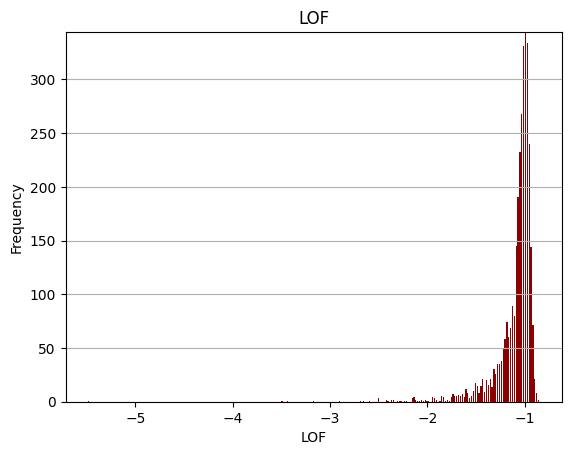

In [14]:
def plot_hist(X: pd.DataFrame, title: str) -> None:
    """ Funcion que genera un grafico de los valores de LOF del dataset """
    x, bins, patches = plt.hist(x=X, bins='auto', rwidth=0.65, color='darkred')
    plt.grid(axis='y')
    plt.xlabel('LOF')
    plt.ylabel('Frequency')
    plt.title(title)
    maxfreq = x.max()
    plt.ylim(ymax=np.ceil(maxfreq))
    
plot_hist(scores, 'LOF')

In [15]:
# Dado el grafico anterior, diremos que un umbral de corte sera aproximadamente -1.85
def lof_threshold(v: float, scores: np.ndarray) -> float:
    ''' Retorna la contaminacion del medio '''
    N = len(scores)
    points = scores[scores < v]
    threshold = len(points)/N
    return threshold 

lof_threshold(-2.5, scores) # APROXimadamente -2.5

0.0027472527472527475

In [16]:
lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean', contamination=0.0027472527472527475)
labels = lof.fit_predict(X.values)
indices = list(np.where(labels==1)[0])
X = X.iloc[indices] # actualizamos la cant. de datos para ambos
Y = Y[indices]

In [17]:
print(X.shape, Y.shape)

(3267, 9) (3267,)


# Normalizacion


In [18]:
X_scaled = MinMaxScaler().fit_transform(X.values)

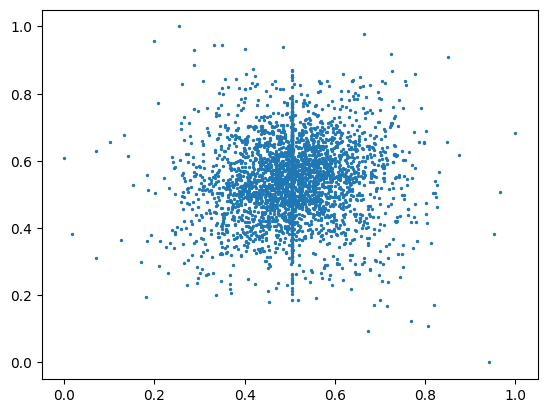

In [19]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=2)
plt.show()

# Stacking SVM kernel:rbf c:1


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3, stratify=Y)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize a RandomForestClassifier
rf = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_parameters)
print("Best Score:", best_score)

# Use the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\Dodo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
326 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Dodo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Dodo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\Dodo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py

Best Parameters: {'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best Score: 0.6513554317601981


In [22]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.95      0.77       598
           1       0.72      0.20      0.32       383

    accuracy                           0.66       981
   macro avg       0.68      0.58      0.54       981
weighted avg       0.68      0.66      0.59       981



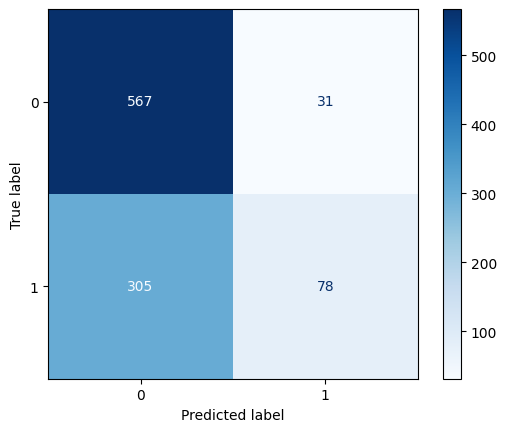

In [23]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues')